In [1]:
pip install download

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/MindSpore/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install download nltk -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/MindSpore/bin/python3.7 -m pip install --upgrade pip' command.


# 1. 数据处理
## 1.1 数据集下载
我们本次使用的数据集为Multi30K数据集，它是一个大规模的图像-文本数据集，包含30K+图片，每张图片都有对应的德文和英文的文本描述。
在本次文本翻译任务中，德语是源语言（source languag），英语是目标语言（target language），运行下面的代码下载并展示数据集：

In [1]:
from download import download
import re

url = "https://modelscope.cn/api/v1/datasets/SelinaRR/Multi30K/repo?Revision=master&FilePath=Multi30K.zip"

download(url, './', kind='zip', replace=True)

datasets_path = './datasets/'
train_path = datasets_path + 'train/'
valid_path = datasets_path + 'valid/'
test_path = datasets_path + 'test/'

def print_data(data_file_path, print_n=5):
    print("=" * 40 + "datasets in {}".format(data_file_path) + "=" * 40)
    with open(data_file_path, 'r', encoding='utf-8') as en_file:
        en = en_file.readlines()[:print_n]
        for index, seq in enumerate(en):
            print(index, seq.replace('\n', ''))


print_data(train_path + 'train.de')
print_data(train_path + 'train.en')


file_sizes: 1.37MB [00:00, 21.5MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ./
========================================datasets in ./datasets/train/train.de========================================
0 Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
1 Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
2 Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
3 Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
4 Zwei Männer stehen am Herd und bereiten Essen zu.
========================================datasets in ./datasets/train/train.en========================================
0 Two young, White males are outside near many bushes.
1 Several men in hard hats are operating a giant pulley system.
2 A little girl climbing into a wooden playhouse.
3 A man in a blue shirt is standing on a ladder cleaning a window.
4 Two men are at the stove preparing food.


## 1.2 数据读取
加载数据集，并进行分词，即将句子拆解为单独的词元（token，可以为字符或者单词）。一般在机器翻译类任务中，我们习惯进行单词级词元化，即每个词元要么为一个单词，要么为一个标点符号。同一个单词，不论首字母是否大写，都应该对应同一个词元，故在分词前，我们需统一将单词转换为小写。
"Hello world!" --> ["hello", "world", "!"]
接下来，我们创建数据加载器Multi30K。后期调用该类进行遍历时，每次返回当前源语言（德语）与目标语言（英语）文本描述的词元列表。

In [2]:
import os

class Multi30K():
    """Multi30K数据集加载器，加载Multi30K数据集并处理为一个Python迭代对象"""
    def __init__(self, path):
        self.data = self._load(path)

    def _load(self, path):
        def tokenize(text):
            text = text.rstrip()
            return [tok.lower() for tok in re.findall(r'\w+|[^\w\s]', text)]
        
        def read_data(data_file_path):
            with open(data_file_path, 'r', encoding='utf-8') as data_file:
                data = data_file.readlines()[:-1]
                return [tokenize(i) for i in data]

        members = {i.split('.')[-1]: path + i for i in os.listdir(path)}
        ret = [read_data(members['de']), read_data(members['en'])]
        return list(zip(*ret))
        
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)

train_dataset, valid_dataset, test_dataset = Multi30K(train_path), Multi30K(valid_path), Multi30K(test_path)

for de, en in train_dataset:
    print(f'德文：{de}')
    print(f'英文：{en}')
    break

德文：['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
英文：['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


## 1.3 构建词典
将每个词元映射到从0开始的数字索引中（为节约存储空间，可过滤掉词频低的词元），词元和数字索引所构成的集合叫做词典（vocabulary）。
以上述“Hello world!”为例，该序列组成的词典为：
{"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3, "hello": 4, "world": 5, "!": 6}
在构建词典中，我们使用了4个特殊词元。
<unk>：未知词元（unknown），将出现次数少于一定频率的单词统一判定为未知词元；
<bos>：起始词元（begin of sentence），用来标注一个句子的开始；
<eos>：结束词元（end of sentence），用来标注一个句子的结束；
<pad>：填充词元（padding），当句子长度不够时将句子填充至统一长度；
通过Vocab创建词典后，我们可以实现词元与数字索引之间的互相转换。我们可以通过调用enocde函数，获取输入词元对应的数字索引，通过调用decode函数，获取输入数字索引对应的词元。同样，我们也可以完成词元列表和数字索引列表之间的转换。

In [3]:
class Vocab:
    """通过词频字典，构建词典"""

    special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']

    def __init__(self, word_count_dict, min_freq=1):
        self.word2idx = {}
        for idx, tok in enumerate(self.special_tokens):
            self.word2idx[tok] = idx

        filted_dict = {w: c for w, c in word_count_dict.items() if c >= min_freq}
        for w, _ in filted_dict.items():
            self.word2idx[w] = len(self.word2idx)

        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        self.bos_idx = self.word2idx['<bos>']
        self.eos_idx = self.word2idx['<eos>']
        self.pad_idx = self.word2idx['<pad>']
        self.unk_idx = self.word2idx['<unk>']

    def _word2idx(self, word):
        """单词映射至数字索引"""
        if word not in self.word2idx:
            return self.unk_idx
        return self.word2idx[word]

    def _idx2word(self, idx):
        """数字索引映射至单词"""
        if idx not in self.idx2word:
            raise ValueError('input index is not in vocabulary.')
        return self.idx2word[idx]

    def encode(self, word_or_list):
        """将单个单词或单词数组映射至单个数字索引或数字索引数组"""
        if isinstance(word_or_list, list):
            return [self._word2idx(i) for i in word_or_list]
        return self._word2idx(word_or_list)

    def decode(self, idx_or_list):
        """将单个数字索引或数字索引数组映射至单个单词或单词数组"""
        if isinstance(idx_or_list, list):
            return [self._idx2word(i) for i in idx_or_list]
        return self._idx2word(idx_or_list)

    def __len__(self):
        return len(self.word2idx)

使用collections中的Counter和OrderedDict统计英/德语每个单词在整体文本中出现的频率。构建词频字典，然后再将词频字典转为词典。其中，收录所有源语言（德语）词元的词典为de_vocab，收录所有目标语言（英语）词元的词典为en_vocab。
在分配数字索引时有一个小技巧：常用的词元对应数值较小的索引，这样可以节约检索时间。

In [4]:
from collections import Counter, OrderedDict

def build_vocab(dataset):
    de_words, en_words = [], []
    for de, en in dataset:
        de_words.extend(de)
        en_words.extend(en)
    
    de_count_dict = OrderedDict(sorted(Counter(de_words).items(), key=lambda t: t[1], reverse=True))
    en_count_dict = OrderedDict(sorted(Counter(en_words).items(), key=lambda t: t[1], reverse=True))

    return Vocab(de_count_dict, min_freq=2), Vocab(en_count_dict, min_freq=2)

de_vocab, en_vocab = build_vocab(train_dataset)
print('Unique tokens in de vocabulary:{} and en vocabulary:{}\n'.format(len(de_vocab), len(en_vocab)))

str_seq_en = ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
print("word:{}\nindex:{}\n".format(str_seq_en, en_vocab.encode(str_seq_en)))

index = [5, 6, 7, 8, 9, 10]
print("index:{}\nword:{}".format(index, en_vocab.decode(index)))

Unique tokens in de vocabulary:7882 and en vocabulary:5898

word:['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
index:[16, 24, 15, 25, 776, 17, 57, 80, 204, 1305, 5]

index:[5, 6, 7, 8, 9, 10]
word:['.', 'in', 'the', 'on', 'man', 'is']


## 1.4 数据迭代器
数据处理的最后一步是创建数据迭代器。截至目前，我们已经通过数据加载器Multi30K将源语言（德语）与目标语言（英语）的文本描述转换为词元序列，并构建了词元与数字索引一一对应的词典，接下来，需要将词元序列转换为数字索引序列。

In [5]:
import mindspore

class Iterator():
    """创建数据迭代器"""
    def __init__(self, dataset, de_vocab, en_vocab, batch_size, max_len=32, drop_reminder=False):
        self.dataset = dataset
        self.de_vocab = de_vocab
        self.en_vocab = en_vocab

        self.batch_size = batch_size
        self.max_len = max_len
        self.drop_reminder = drop_reminder

        length = len(self.dataset) // batch_size
        self.len = length if drop_reminder else length + 1  # 批量数量

    def __call__(self):
        def pad(idx_list, vocab, max_len):
            """统一序列长度，并记录有效长度"""
            idx_pad_list, idx_len = [], []
            for i in idx_list:
                if len(i) > max_len - 2:
                    idx_pad_list.append([vocab.bos_idx] + i[:max_len-2] + [vocab.eos_idx])
                    idx_len.append(max_len)
                else:
                    idx_pad_list.append([vocab.bos_idx] + i + [vocab.eos_idx] + [vocab.pad_idx] * (max_len - len(i) - 2))
                    idx_len.append(len(i) + 2)
            return idx_pad_list, idx_len

        def sort_by_length(src, trg):
            """根据src的字段长度进行排序"""
            data = zip(src, trg)
            data = sorted(data, key=lambda t: len(t[0]), reverse=True)
            return zip(*list(data))

        def encode_and_pad(batch_data, max_len):
            """将批量中的文本数据转换为数字索引，并统一每个序列的长度"""
            src_data, trg_data = zip(*batch_data)
            src_idx = [self.de_vocab.encode(i) for i in src_data]
            trg_idx = [self.en_vocab.encode(i) for i in trg_data]

            src_idx, trg_idx = sort_by_length(src_idx, trg_idx)
            src_idx_pad, src_len = pad(src_idx, de_vocab, max_len)
            trg_idx_pad, _ = pad(trg_idx, en_vocab, max_len)

            return src_idx_pad, src_len, trg_idx_pad

        for i in range(self.len):
            if i == self.len - 1 and not self.drop_reminder:
                batch_data = self.dataset[i * self.batch_size:]
            else:
                batch_data = self.dataset[i * self.batch_size: (i+1) * self.batch_size]

            src_idx, src_len, trg_idx = encode_and_pad(batch_data, self.max_len)
            yield mindspore.Tensor(src_idx, mindspore.int32), \
                mindspore.Tensor(src_len, mindspore.int32), \
                mindspore.Tensor(trg_idx, mindspore.int32)

    def __len__(self):
        return self.len

train_iterator = Iterator(train_dataset, de_vocab, en_vocab, batch_size=128, max_len=32, drop_reminder=True)
valid_iterator = Iterator(valid_dataset, de_vocab, en_vocab, batch_size=128, max_len=32, drop_reminder=False)
test_iterator = Iterator(test_dataset, de_vocab, en_vocab, batch_size=1, max_len=32, drop_reminder=False)

for src_idx, src_len, trg_idx in train_iterator():
    print(f'src_idx.shape:{src_idx.shape}\n{src_idx}\nsrc_len.shape:{src_len.shape}\n{src_len}\ntrg_idx.shape:{trg_idx.shape}\n{trg_idx}')
    break

src_idx.shape:(128, 32)
[[ 2  5 13 ...  1  1  1]
 [ 2  5 13 ...  1  1  1]
 [ 2  5 13 ...  1  1  1]
 ...
 [ 2  5 52 ...  1  1  1]
 [ 2  8 37 ...  1  1  1]
 [ 2  5 33 ...  1  1  1]]
src_len.shape:(128,)
[27 25 24 24 23 23 23 23 22 22 22 21 21 21 21 21 20 20 20 20 20 19 19 19
 18 18 18 18 18 18 18 18 17 17 17 17 17 17 17 17 17 17 16 16 16 16 16 16
 16 16 16 16 15 15 15 15 15 15 15 15 15 15 15 14 14 14 14 14 14 14 14 14
 14 14 14 14 13 13 13 13 13 13 13 13 13 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 11 11 11 11 11 11 11 11 11 11 10 10 10 10 10 10
 10  9  9  9  9  9  9  8]
trg_idx.shape:(128, 32)
[[   2    4 2243 ...    1    1    1]
 [   2    4    9 ...    1    1    1]
 [   2    4    9 ...    1    1    1]
 ...
 [   2    4   55 ...    1    1    1]
 [   2    4   38 ...    1    1    1]
 [   2    4   35 ...    1    1    1]]


## 1.5 Word Embedding
词元token的索引index无法准确表示词的含义，为此我们引入词向量来表示词元。word embedding操作就是把词元的索引映射到词向量的过程。刚开始训练时，词向量是随机初始化的，训练后期才趋于准确，因此下面的代码在执行时的结果具有随机性。另外，不同的任务对词向量的维度要求也不一样，这里的维度可以简单理解为词性分析。

In [6]:
from mindspore import nn, Tensor

word_index = Tensor([21, 28, 49, 12, 275, 119, 49, 23, 54, 32])
src_emb = nn.Embedding(len(de_vocab), 4)
enc_outputs = src_emb(word_index)
print(enc_outputs)

[[ 0.00295856  0.00246902  0.01927644 -0.0023904 ]
 [ 0.00583488  0.01412345  0.0247566   0.0019167 ]
 [ 0.00611447  0.003686   -0.01515237 -0.00593443]
 [ 0.00293611  0.01245644  0.00439978  0.00045637]
 [ 0.0108687   0.00061075  0.00330704  0.01208935]
 [ 0.00699233 -0.01241017 -0.00177155  0.00241385]
 [ 0.00611447  0.003686   -0.01515237 -0.00593443]
 [-0.00276255 -0.00301438 -0.00112235  0.01240857]
 [-0.00383354  0.01041119 -0.00320785 -0.00333949]
 [-0.01160093  0.01672551  0.01234155  0.00110833]]


## 1.6 位置编码
在下面的代码中，我们实现了位置编码，输入经过word embedding后的结果𝑋，输出添加位置信息后的结果𝑋+𝑃𝐸。

In [7]:
import mindspore
from mindspore import nn, ops, Tensor
from mindspore import dtype as mstype
from mindspore import numpy as mnp

class PositionalEncoding(nn.Cell):
    """位置编码"""

    def __init__(self, d_model, dropout_p=0.1, max_len=100):
        super().__init__()
        self.dropout = nn.Dropout(1 - dropout_p)

        self.pe = ops.Zeros()((max_len, d_model), mstype.float32)

        pos = mnp.arange(0, max_len, dtype=mstype.float32).view((-1, 1))
        angle = ops.pow(10000.0, mnp.arange(0, d_model, 2, dtype=mstype.float32)/d_model)

        self.pe[:, 0::2] = ops.sin(pos/angle)
        self.pe[:, 1::2] = ops.cos(pos/angle)

    def construct(self, x):
        batch_size = x.shape[0]

        pe = self.pe.expand_dims(0)
        pe = ops.broadcast_to(pe, (batch_size, -1, -1))

        x = x + pe[:, :x.shape[1], :]
        return self.dropout(x)

x = ops.Zeros()((1, 10, 4), mstype.float32)
pe = PositionalEncoding(4)
print(pe(x))

[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:04.679.006 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


[[[ 0.          1.          0.          1.        ]
  [ 0.841471    0.5403023   0.00999983  0.99995   ]
  [ 0.9092974  -0.4161468   0.01999867  0.9998    ]
  [ 0.14112    -0.9899925   0.0299955   0.99955004]
  [-0.7568025  -0.6536436   0.03998933  0.9992001 ]
  [-0.9589243   0.28366217  0.04997917  0.99875027]
  [-0.2794155   0.96017027  0.059964    0.99820054]
  [ 0.6569866   0.75390226  0.06994285  0.997551  ]
  [ 0.98935825 -0.14550003  0.07991469  0.99680173]
  [ 0.41211846 -0.91113025  0.08987855  0.9959527 ]]]


# 2. 模型结构
## 2.1 注意力机制
在如下代码中，我们实现了scaled dot-product attention的计算， 调用类后，返回的是加权后的value（output）以及注意力权重（attn）。

In [8]:
class ScaledDotProductAttention(nn.Cell):
    def __init__(self, dropout_p=0.):
        super().__init__()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(1-dropout_p)
        self.sqrt = ops.Sqrt()


    def construct(self, query, key, value, attn_mask=None):
        """scaled dot product attention"""
        embed_size = query.shape[-1]
        scaling_factor = self.sqrt(Tensor(embed_size, mstype.float16))

        attn = ops.matmul(query, key.swapaxes(-2, -1) / scaling_factor)

        if attn_mask is not None:
            attn = attn.masked_fill(attn_mask, -1e9)
        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = ops.matmul(attn, value)

        return (output, attn)


attention = ScaledDotProductAttention()
q_s = k_s = v_s = ops.ones((128, 8, 32, 64), mindspore.float32)
attn_mask = ops.ones((128, 8, 32, 32), mindspore.float32)
attn_mask = mindspore.ops.gt(attn_mask, attn_mask)
output, attn = attention(q_s, k_s, v_s, attn_mask)
print(output.shape, attn.shape)

[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:07.917.598 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


(128, 8, 32, 64) (128, 8, 32, 32)


[WARNING] KERNEL(69980,7f9677021700,python):2025-12-19-15:27:07.927.065 [mindspore/ccsrc/plugin/device/gpu/kernel/gpu_kernel.cc:40] CheckDeviceSm] It is recommended to use devices with a computing capacity >= 7, but the current device's computing capacity is 6


## 2.2 多头注意力（Multi-Head Attention）
在多头注意力中，每个头部可以'解读'输入内容的不同方面，比如：捕捉全局依赖关系、关注特定语境下的词元、识别词和词之间的语法关系等。

In [9]:
class MultiHeadAttention(nn.Cell):
    def __init__(self, d_model, d_k, n_heads, dropout_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_k
        self.W_Q = nn.Dense(d_model, d_k * n_heads)
        self.W_K = nn.Dense(d_model, d_k * n_heads)
        self.W_V = nn.Dense(d_model, d_k * n_heads)
        self.W_O = nn.Dense(n_heads * d_k, d_model)
        self.attention = ScaledDotProductAttention(dropout_p=dropout_p)

    def construct(self, query, key, value, attn_mask):
        """
        query: [batch_size, len_q, d_model]
        key: [batch_size, len_k, d_model]
        value: [batch_size, len_k, d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        """

        batch_size = query.shape[0]

        q_s = self.W_Q(query).view(batch_size, -1, self.n_heads, self.d_k)
        k_s = self.W_K(key).view(batch_size, -1, self.n_heads, self.d_k)
        v_s = self.W_V(value).view(batch_size, -1, self.n_heads, self.d_k)

        q_s = q_s.transpose((0, 2, 1, 3))
        k_s = k_s.transpose((0, 2, 1, 3))
        v_s = v_s.transpose((0, 2, 1, 3))

        attn_mask = attn_mask.expand_dims(1)
        attn_mask = ops.tile(attn_mask, (1, self.n_heads, 1, 1))

        context, attn = self.attention(q_s, k_s, v_s, attn_mask)

        context = context.transpose((0, 2, 1, 3)).view((batch_size, -1, self.n_heads * self.d_k))

        output = self.W_O(context)

        return output, attn

enc_input = ops.ones((128, 32, 512), mindspore.float32)
attn_mask = ops.ones((128, 32, 32), mindspore.float32)
attn_mask = mindspore.ops.gt(attn_mask, attn_mask)

mha = MultiHeadAttention(512, 64, 8)
output, attn = mha(enc_input, enc_input, enc_input, attn_mask)
print("output.shape:{}\nattn_mask.shape:{}\n".format(output.shape, attn.shape))

[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:09.966.052 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


output.shape:(128, 32, 512)
attn_mask.shape:(128, 8, 32, 32)



In [10]:
def get_attn_pad_mask(seq_q, seq_k, pad_idx):
    """注意力掩码：识别序列中的<pad>占位符

    Args:
        seq_q (Tensor): query序列，shape = [batch size, query len]
        seq_k (Tensor): key序列，shape = [batch size, key len]
        pad_idx (Tensor): key序列<pad>占位符对应的数字索引
    """
    batch_size, len_q = seq_q.shape
    batch_size, len_k = seq_k.shape

    pad_attn_mask = ops.equal(seq_k, pad_idx)

    pad_attn_mask = pad_attn_mask.expand_dims(1)
    pad_attn_mask = ops.broadcast_to(pad_attn_mask, (batch_size, len_q, len_k))

    return pad_attn_mask

q = k = Tensor([[1, 1, 0, 0]], mstype.float32)
pad_idx = 0
mask = get_attn_pad_mask(q, k, pad_idx)
print(mask)

[[[False False  True  True]
  [False False  True  True]
  [False False  True  True]
  [False False  True  True]]]


## 2.3 基于位置的前馈神经网络

In [11]:
class PoswiseFeedForward(nn.Cell):
    def __init__(self, d_ff, d_model, dropout_p=0.):
        super().__init__()
        self.linear1 = nn.Dense(d_model, d_ff)
        self.linear2 = nn.Dense(d_ff, d_model)
        self.dropout = nn.Dropout(1-dropout_p)
        self.relu = nn.ReLU()

    def construct(self, x):
        """前馈神经网络
        x: [batch_size, seq_len, d_model]
        """
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.linear2(x)
        return output

x = ops.ones((128, 32, 512), mstype.float32)
ffn = PoswiseFeedForward(2048, 512)
print(ffn(x).shape)

[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:14.981.229 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


(128, 32, 512)


## 2.4 Add&Norm

In [12]:
class AddNorm(nn.Cell):
    def __init__(self, d_model, dropout_p=0.):
        super().__init__()
        self.layer_norm = nn.LayerNorm((d_model, ), epsilon=1e-5)
        self.dropout = nn.Dropout(1-dropout_p)
    
    def construct(self, x, residual):
        return self.layer_norm(self.dropout(x) + residual)

## 2.5 编码网络
我们首先实现encoder中的一个层。

In [13]:
class EncoderLayer(nn.Cell):
    def __init__(self, d_model, n_heads, d_ff, dropout_p=0.):
        super().__init__()
        d_k = d_model // n_heads
        if d_k * n_heads != d_model:
            raise ValueError(f"The `d_model` {d_model} can not be divisible by `num_heads` {n_heads}.")
        self.enc_self_attn = MultiHeadAttention(d_model, d_k, n_heads, dropout_p)
        self.pos_ffn = PoswiseFeedForward(d_ff, d_model, dropout_p)
        self.add_norm1 = AddNorm(d_model, dropout_p)
        self.add_norm2 = AddNorm(d_model, dropout_p)
        
    def construct(self, enc_inputs, enc_self_attn_mask):
        """
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        """
        residual = enc_inputs

        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)

        enc_outputs = self.add_norm1(enc_outputs, residual)
        residual = enc_outputs

        enc_outputs = self.pos_ffn(enc_outputs)

        enc_outputs = self.add_norm2(enc_outputs, residual)

        return enc_outputs, attn

x = ops.ones((128, 32, 512), mstype.float32)
mask = Tensor([False]).broadcast_to((128, 32, 32))
encoder_layer = EncoderLayer(512, 8, 2018)
output, attn = encoder_layer(x, mask)
print(output.shape, attn.shape)

[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:18.247.343 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:18.287.844 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:18.291.677 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:18.294.591 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


(128, 32, 512) (128, 8, 32, 32)


将上面实现的encoder层堆叠n_layers次，并添加wording embedding与positional encoding。

In [14]:
class Encoder(nn.Cell):
    def __init__(self, src_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.):
        super().__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, dropout_p)
        self.layers = nn.CellList([EncoderLayer(d_model, n_heads, d_ff, dropout_p)] * n_layers)
        self.scaling_factor = ops.Sqrt()(Tensor(d_model, mstype.float32))

    def construct(self, enc_inputs, src_pad_idx):
        """enc_inputs : [batch_size, src_len]
        """
        enc_outputs = self.src_emb(enc_inputs.astype(mstype.int32))
        enc_outputs = self.pos_emb(enc_outputs * self.scaling_factor)

        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs, src_pad_idx)

        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

encoder = Encoder(len(de_vocab), 512, 8, 2048, 6)

for src_idx, src_len, trg_idx in train_iterator():
    enc_outputs, enc_self_attns = encoder(src_idx, de_vocab.pad_idx)
    print("enc_outputs.shape:{}\n".format(enc_outputs.shape))
    break

[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:20.457.400 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:20.517.124 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:20.558.629 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:20.562.458 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:20.565.864 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


enc_outputs.shape:(128, 32, 512)



In [15]:
def get_attn_subsequent_mask(seq_q, seq_k):
    """生成时间掩码，使decoder在第t时刻只能看到序列的前t-1个元素
    
    Args:
        seq_q (Tensor): query序列，shape = [batch size, len_q]
        seq_k (Tensor): key序列，shape = [batch size, len_k]
    """
    batch_size, len_q = seq_q.shape
    batch_size, len_k = seq_k.shape
    ones = ops.ones((batch_size, len_q, len_k), mindspore.float32)
    subsequent_mask = mnp.triu(ones, k=1)
    return subsequent_mask

q = k = ops.ones((1, 4), mstype.float32)
mask = get_attn_subsequent_mask(q, k)
print(mask)

[[[0. 1. 1. 1.]
  [0. 0. 1. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 0.]]]


## 2.6 解码网络
首先实现Decoder中的一个层。

In [16]:
class DecoderLayer(nn.Cell):
    def __init__(self, d_model, n_heads, d_ff, dropout_p=0.):
        super().__init__()
        d_k = d_model // n_heads
        if d_k * n_heads != d_model:
            raise ValueError(f"The `d_model` {d_model} can not be divisible by `num_heads` {n_heads}.")
        self.dec_self_attn = MultiHeadAttention(d_model, d_k, n_heads, dropout_p)
        self.dec_enc_attn = MultiHeadAttention(d_model, d_k, n_heads, dropout_p)
        self.pos_ffn = PoswiseFeedForward(d_ff, d_model, dropout_p)
        self.add_norm1 = AddNorm(d_model, dropout_p)
        self.add_norm2 = AddNorm(d_model, dropout_p)
        self.add_norm3 = AddNorm(d_model, dropout_p)
        
    def construct(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        """
        dec_inputs: [batch_size, trg_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, trg_len, trg_len]
        dec_enc_attn_mask: [batch_size, trg_len, src_len]
        """
        residual = dec_inputs
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs = self.add_norm1(dec_outputs, residual)
        residual = dec_outputs    
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.add_norm2(dec_outputs, residual)
        residual = dec_outputs
        dec_outputs = self.pos_ffn(dec_outputs)
        dec_outputs = self.add_norm3(dec_outputs, residual)

        return dec_outputs, dec_self_attn, dec_enc_attn

x = y = ops.ones((128, 32, 512), mstype.float32)
mask1 = mask2 = Tensor([False]).broadcast_to((128, 32, 32))
decoder_layer = DecoderLayer(512, 8, 2048)
output, attn1, attn2 = decoder_layer(x, y, mask1, mask2)
print(output.shape, attn1.shape, attn2.shape)

[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:24.177.150 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:24.204.265 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:24.247.938 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:24.252.251 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:24.255.412 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:14028851053

(128, 32, 512) (128, 8, 32, 32) (128, 8, 32, 32)


将上面实现的DecoderLayer堆叠n_layer次，添加word embedding与positional encoding，以及最后的线性层。
输出的dec_outputs为对目标序列的预测。

In [17]:
class Decoder(nn.Cell):
    def __init__(self, trg_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.):
        super().__init__()
        self.trg_emb = nn.Embedding(trg_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, dropout_p)
        self.layers = nn.CellList([DecoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)])
        self.projection = nn.Dense(d_model, trg_vocab_size)
        self.scaling_factor = ops.Sqrt()(Tensor(d_model, mstype.float32))      
        
    def construct(self, dec_inputs, enc_inputs, enc_outputs, src_pad_idx, trg_pad_idx):
        """
        dec_inputs: [batch_size, trg_len]
        enc_inputs: [batch_size, src_len]
        enc_outputs: [batch_size, src_len, d_model]
        """
        dec_outputs = self.trg_emb(dec_inputs.astype(mstype.int32))
        dec_outputs = self.pos_emb(dec_outputs * self.scaling_factor)

        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, trg_pad_idx)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs, dec_inputs)
        dec_self_attn_mask = ops.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, src_pad_idx)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)

        dec_outputs = self.projection(dec_outputs)
        return dec_outputs, dec_self_attns, dec_enc_attns

## 2.7 Transformer
将实现的Encoder与Decoder组合起来。

In [18]:
class Transformer(nn.Cell):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.encoder.to_float(mindspore.float32)
        self.decoder.to_float(mindspore.float32)
        
    def construct(self, enc_inputs, dec_inputs, src_pad_idx, trg_pad_idx):
        """
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, trg_len]
        """
        enc_outputs, enc_self_attns = self.encoder(enc_inputs, src_pad_idx)

        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs, src_pad_idx, trg_pad_idx)

        dec_logits = dec_outputs.view((-1, dec_outputs.shape[-1]))

        return dec_logits, enc_self_attns, dec_self_attns, dec_enc_attns

# 3. 模型训练
## 3.1 定义超参数&实例化Transformer模型

In [19]:
src_vocab_size = len(de_vocab)
trg_vocab_size = len(en_vocab)
src_pad_idx = de_vocab.pad_idx
trg_pad_idx = en_vocab.pad_idx

d_model = 512
d_ff = 2048
n_layers = 2
n_heads = 8

encoder = Encoder(src_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.1)
decoder = Decoder(trg_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.1)
model = Transformer(encoder, decoder)

[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:44.416.142 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:44.451.551 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:44.489.494 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:44.493.064 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:27:44.725.520 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:14028851053

## 3.2 定义损失函数与优化器

In [20]:
loss_fn = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)
optimizer = nn.Adam(model.trainable_params(), learning_rate=0.0001)

## 3.3 模型训练逻辑
1、Network+loss function直接构造正向函数
2、函数变换，获得梯度计算（反向传播）函数
3、构造训练过程函数
4、调用函数进行训练
## 3.4 定义前向网络计算逻辑

In [21]:
def forward(enc_inputs, dec_inputs):
    """前向网络
    enc_inputs: [batch_size, src_len]
    dec_inputs: [batch_size, trg_len]
    """
    logits, _, _, _ = model(enc_inputs, dec_inputs[:, :-1], src_pad_idx, trg_pad_idx)

    targets = dec_inputs[:, 1:].view(-1)
    loss = loss_fn(logits, targets)

    return loss

## 3.5 定义梯度计算函数

In [22]:
grad_fn = ops.value_and_grad(forward, None, optimizer.parameters)

## 3.6 定义模型训练函数

In [23]:
from tqdm import tqdm

def train(iterator, epoch=0):
    model.set_train(True)
    num_batches = len(iterator)
    total_loss = 0
    total_steps = 0

    with tqdm(total=num_batches, unit='step', desc='Train   ') as t:
        for src, src_len, trg in iterator():
            loss, grads = grad_fn(src, trg)
            optimizer(grads)

            total_loss += loss.asnumpy()
            total_steps += 1
            curr_loss = total_loss / total_steps
            t.set_postfix({'loss': f'{curr_loss:.2f}', 'epoch': f'{epoch:03}'})
            t.update(1)

    return total_loss / total_steps

## 3.7 定义模型评估逻辑

In [24]:
def evaluate(iterator):
    model.set_train(False)
    num_batches = len(iterator)
    total_loss = 0
    total_steps = 0

    with tqdm(total=num_batches, unit='step', desc='Evaluate') as t:
        for src, _, trg in iterator():
            loss = forward(src, trg)
            total_loss += loss.asnumpy()
            total_steps += 1
            curr_loss = total_loss / total_steps
            t.set_postfix({'loss': f'{curr_loss:.2f}'})
            t.update(1)

    return total_loss / total_steps

## 3.8 模型训练
数据集遍历迭代，一次完整的数据集遍历成为一个epoch。我们逐个epoch打印训练的损失值和评估精度，并通过save_checkpoint保存评估精度最高的ckpt文件（transformer.ckpt）到home_path/.mindspore_examples/transformer.ckpt。

Evaluate: 100%|██████████| 8/8 [00:01<00:00,  4.09step/s, loss=1.82]


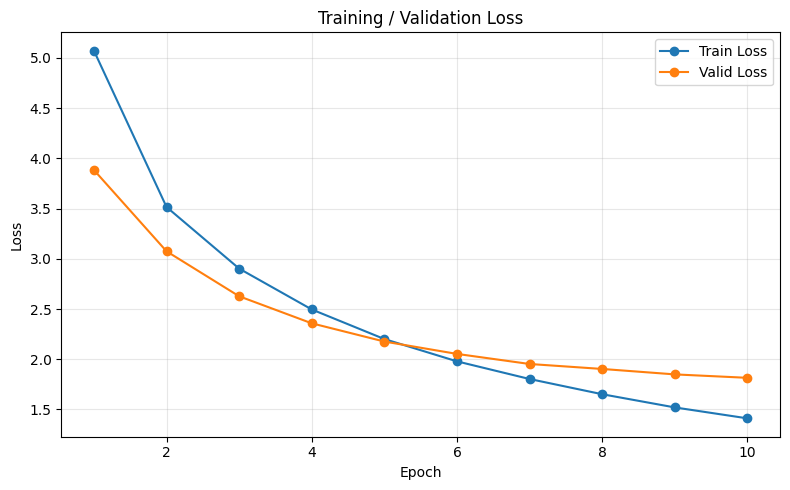

In [25]:
import matplotlib.pyplot as plt
from mindspore import save_checkpoint

num_epochs = 10
best_valid_loss = float('inf')
ckpt_file_name = 'transformer_2layer.ckpt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = train(train_iterator, epoch)
    valid_loss = evaluate(valid_iterator)

    # 如果返回的是 Tensor/ndarray，转成 float（按需保留）
    try:
        train_loss = float(train_loss.asnumpy())
    except Exception:
        train_loss = float(train_loss)

    try:
        valid_loss = float(valid_loss.asnumpy())
    except Exception:
        valid_loss = float(valid_loss)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_checkpoint(model, ckpt_file_name)

# 画图
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, valid_losses, marker='o', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# 4. 模型推理

In [26]:
from mindspore import load_checkpoint, load_param_into_net

encoder = Encoder(src_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.1)
decoder = Decoder(trg_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.1)
new_model = Transformer(encoder, decoder)

param_dict = load_checkpoint(ckpt_file_name)
load_param_into_net(new_model, param_dict)

def inference(sentence, max_len=32):
    """模型推理：输入一个德语句子，输出翻译后的英文句子
    enc_inputs: [batch_size(1), src_len]
    """
    new_model.set_train(False)

    if isinstance(sentence, str):
        tokens = [tok.lower() for tok in re.findall(r'\w+|[^\w\s]', sentence.rstrip())]
    else:
        tokens = [token.lower() for token in sentence]

    if len(tokens) > max_len - 2:
        src_len = max_len
        tokens = ['<bos>'] + tokens[:max_len - 2] + ['<eos>']
    else:
        src_len = len(tokens) + 2
        tokens = ['<bos>'] + tokens + ['<eos>'] + ['<pad>'] * (max_len - src_len)

    indexes = de_vocab.encode(tokens)
    enc_inputs = Tensor(indexes, mstype.float32).expand_dims(0)

    enc_outputs, _ = new_model.encoder(enc_inputs, src_pad_idx)

    dec_inputs = Tensor([[en_vocab.bos_idx]], mstype.float32)

    max_len = enc_inputs.shape[1]
    for _ in range(max_len):
        dec_outputs, _, _ = new_model.decoder(dec_inputs, enc_inputs, enc_outputs, src_pad_idx, trg_pad_idx)
        dec_logits = dec_outputs.view((-1, dec_outputs.shape[-1]))

        dec_logits = dec_logits[-1, :]
        pred = dec_logits.argmax(axis=0).expand_dims(0).expand_dims(0)
        pred = pred.astype(mstype.float32)

        dec_inputs = ops.concat((dec_inputs, pred), axis=1)

        if int(pred.asnumpy()[0]) == en_vocab.eos_idx:
            break

    trg_indexes = [int(i) for i in dec_inputs.view(-1).asnumpy()]
    eos_idx = trg_indexes.index(en_vocab.eos_idx) if en_vocab.eos_idx in trg_indexes else -1
    trg_tokens = en_vocab.decode(trg_indexes[1:eos_idx])

    return trg_tokens

example_idx = 0

src = test_dataset[example_idx][0]
trg = test_dataset[example_idx][1]
pred_trg = inference(src)

print(f'src = {src}')
print(f'trg = {trg}')
print(f"predicted trg = {pred_trg}")

[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:44:14.950.183 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:44:14.984.611 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:44:15.236.11 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:44:15.273.11 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:140288510531392,MainProcess):2025-12-19-15:44:15.302.96 [mindspore/nn/layer/basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(69980:14028851053139

src = ['ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', 'anstarrt', '.']
trg = ['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.']
predicted trg = ['a', 'man', 'in', 'an', 'orange', 'hat', ',', '<unk>', 'to', 'something', '.']


# 5. BLEU得分
调用nltk中的corpus_bleu函数来计算BLEU。

In [27]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(dataset, max_len=50):
    trgs = []
    pred_trgs = []
    
    for data in dataset[:10]:
        
        src = data[0]
        trg = data[1]

        pred_trg = inference(src, max_len)
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return corpus_bleu(trgs, pred_trgs)

bleu_score = calculate_bleu(test_dataset)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 39.74
